In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# extract pcs sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:

map_pixel_to_grid_spot_file_path = "/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Jsons/map_pixel_to_grid_spot.json"
background_path = "/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/backgrounds.npy"
foreground_path = "/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/foregrounds.npy"
pixel_barcode_file_path = "/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/pixel_barcode.npy"

pca_file_path = "/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/mapped_14.npy"

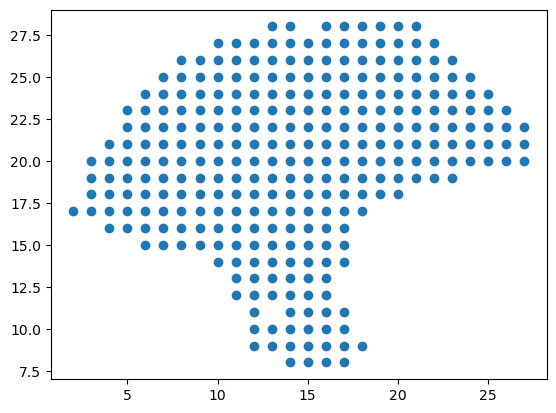

In [7]:
# Read the data tsv file
data = pd.read_csv('../Test/data/Melanoma/originial/ST_mel1_rep2_counts.tsv', sep='\t')

x_pixels = []
y_pixels = []
for spot in data.columns:
    if spot != 'gene':
        y_pixels.append(int(spot.split('x')[0])+1)
        x_pixels.append(int(spot.split('x')[1])-1)
plt.scatter(x_pixels, y_pixels)

In [8]:
X = data.drop('gene', axis=1).values.T
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)

mapped_14 = np.zeros((max(y_pixels)+1, max(x_pixels)+1, 14))
for i in range(len(x_pixels)):
    mapped_14[y_pixels[i], x_pixels[i]] = X_pca[i]

df = pd.DataFrame(X_pca, columns=['PC'+str(i) for i in range(1, 15)], index=data.columns[1:])
df.to_csv('pc14.csv')

np.save(pca_file_path, mapped_14)

In [9]:
def make_grid_idx(x_pixels,y_pixels):
    grid_idx = np.zeros((max(y_pixels)+1,max(x_pixels)+1)) - 1
    for i in range(len(x_pixels)):
        grid_idx[y_pixels[i],x_pixels[i]] = 1
    return grid_idx

def get_pixel_to_grid_spot_map(grid_pixel_coor, grid_idx):
    n = grid_pixel_coor.shape[0]
    m = grid_pixel_coor.shape[1]
    map_pixel_to_grid_spot = {}
    for i in range(n):
        for j in range(m):
            if grid_idx[i, j] != -1:
                map_from = f'({i}, {j})'
                map_to = (i, j)
                map_pixel_to_grid_spot[map_from] = map_to
    return map_pixel_to_grid_spot


(29, 28)


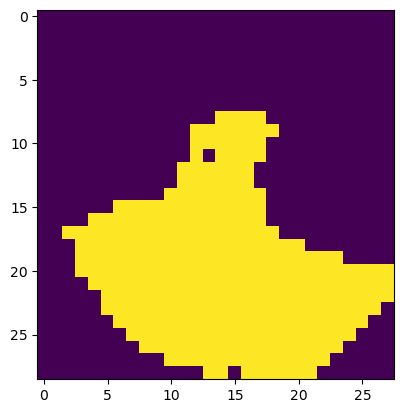

In [10]:
grid_idx = make_grid_idx(x_pixels,y_pixels)
print(grid_idx.shape)
map_pixel_to_grid_spot = get_pixel_to_grid_spot_map(grid_idx, grid_idx)
plt.imshow(grid_idx)

In [ ]:
with open(map_pixel_to_grid_spot_file_path, "w") as outfile:
    json.dump(map_pixel_to_grid_spot, outfile)

In [11]:
backgrounds = np.argwhere(grid_idx == -1)
foregrounds = np.argwhere(grid_idx == 1)

In [12]:
np.save(background_path, backgrounds)
np.save(foreground_path, foregrounds)

In [ ]:
def make_pixel_barcode(grid_idx,x_pixels,y_pixels):
    mx_row,mx_col = grid_idx.shape

    pixel_barcode = np.empty([mx_row + 1, mx_col + 1], dtype='<U100')

    for i in range(len(x_pixels)):
        pixel_barcode[y_pixels[i], x_pixels[i]] = str(y_pixels[i]) + "x" + str(x_pixels[i])
    return pixel_barcode


In [ ]:
pixel_barcode = make_pixel_barcode(grid_idx,x_pixels,y_pixels)
np.save(pixel_barcode_file_path, pixel_barcode)

In [ ]:
new_scribble_spot = np.full_like(scribble_spots, 255)

df_mclust_scribble = pd.read_csv("/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Data/others/Melanoma/mclust_result.csv")
df_mclust_scribble.set_index("Unnamed: 0",inplace=True)
df_mclust_scribble.head()

In [ ]:
x_pixels = []
y_pixels = []
labels = []
for i in range(df_mclust_scribble.shape[0]):
    spot = df_mclust_scribble.index[i]
    x_pixels.append(int(spot.split("x")[1])-1)
    y_pixels.append(int(spot.split("x")[0])+1)
    labels.append(df_mclust_scribble.iloc[i,0])


new_scribble_spot[y_pixels,x_pixels] = labels

In [ ]:
np.save("/mnt/g/wsl-root-me/Thesis/ScribbleSeg/ScribbleSeg_Revision/Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Scribble/mclust_scribble.npy",new_scribble_spot)